#                         Building **CNN** on CIFAR-10 Dataset
- Author : **yashlab**
- DATE   : **Mar/21/20**

In [1]:
# Import Libraries
import torch
import torch.nn as nn
from torchvision import datasets,transforms,models
import numpy as np

In [2]:
# Check for GPU
GPU = torch.device('cuda:0' if torch.cuda.is_available() else None)

if not GPU:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


The major steps in the pipeline are 
- [ ] Download Datasets 
- [ ] Create Loaders
- [ ] View Data
- [ ] Define Model
- [ ] Define Loss and Optimizer
- [ ] Train Model & Observe Performance on Validation
- [ ] Save the Model
- [ ] Test Accuracy

## Data Preparation
---

In [3]:
# DATA preprocessing
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
# Number of Workers to load data
num_workers = 1

# Number of data points (images, in this case) in a batch
batch_size  = 32

In [4]:
# Check for Dataset Availability

train = datasets.CIFAR10('data',train=True,download=True,transform=transform)
test  = datasets.CIFAR10('data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Define Validation Parameters

valid_pct = 0.2 # The percentage of training data to be used for validation set.

total_obs = len(train) 
indxs = list(range(total_obs))
np.random.shuffle(indxs)
split = int(np.floor(valid_pct*total_obs))
train_indxs, valid_indxs = indxs[split:],indxs[:split]


In [6]:
# Create Samplers to randomly sample data in TRAIN and VALIDATION sets
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indxs)
valid_sampler = SubsetRandomSampler(valid_indxs)

In [7]:
# Create Data Loaders

train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=32,
                                          sampler=train_sampler,
                                          num_workers=num_workers)


valid_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=32,
                                          sampler=valid_sampler,
                                          num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=num_workers)

- [x] Download Datasets 
- [x] Create Loaders

In [8]:
classes = ['airplane', 'automobile',
           'bird', 'cat',
           'deer','dog',
           'frog', 'horse',
           'ship', 'truck']

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

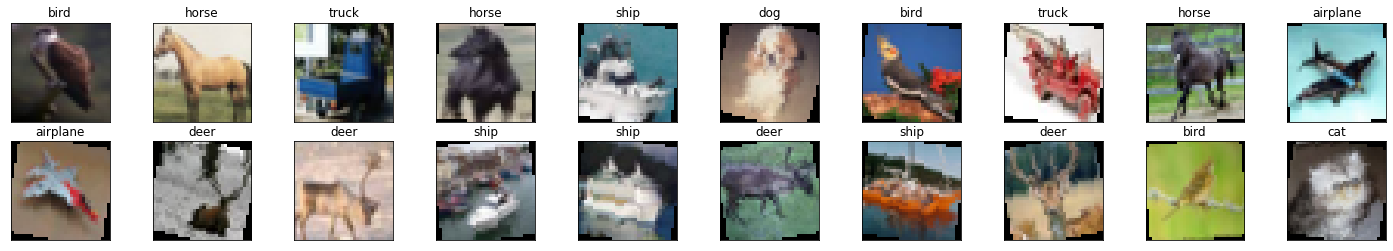

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
import matplotlib.pyplot as plt

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

- [x] View Data

## Define Network Architecture
---

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # Input of (3*32*32)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)
        # Input of (16*16*16)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
        # Input of (8*8*32)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        #Input of (4*4*64)
        
        # Fully Connected Layers
        self.fc1   = nn.Linear(4*4*64,256)
        self.fc2   = nn.Linear(256,64)
        self.fc3   = nn.Linear(64,32)
        self.fc4   = nn.Linear(32,10)
        
        # Other Layers
        self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop  = nn.Dropout(p=0.25)
        self.relu  = nn.ReLU()
        
        
        
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1,4*4*64)
        
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.relu(self.fc3(self.drop(x)))
        x = self.fc4(x)
        return x
        
model = CNN()
model.to(GPU)
    

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [12]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=0.005,momentum=0.9)

- [x] Define Model
- [x] Define Loss and Optimizer

## Train, Validate, Test
---
#### Train and Validate

In [13]:
# Train the Network
epochs = 32

valid_loss_min = np.Inf

for epoch in range(1,epochs+1):
    
    train_loss =0
    valid_loss =0
    model.train()  # Set to train mode
    ############################## TRAIN ############################
    for img,label in train_loader:
        optimizer.zero_grad() # Clear the residual garbage gradients
        
        if GPU: # Move to GPU if CUDA is available
            img,label = img.cuda(),label.cuda()
            
        output = model(img) # Forward Pass
        loss = criterion(output,label) # Calculate the loss
        loss.backward() # Backpropagation step to populate the gradients
        optimizer.step() # Make the weight updates
        
        train_loss+=loss.item()*img.size(0)
        
    ############################ VALIDATION ############################
    model.eval() # Set to evaluation mode
    
    for img,label in valid_loader:
        if GPU:
            img,label = img.cuda(),label.cuda()
            output = model(img) # Forward Pass
            loss = criterion(output,label) # Calculate the loss
            valid_loss += loss.item()*img.size(0)
            
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CIFAR_aug.pt')
        valid_loss_min = valid_loss
        
            



Epoch: 1 	Training Loss: 1.807833 	Validation Loss: 0.403714
Validation loss decreased (inf --> 0.403714).  Saving model ...
Epoch: 2 	Training Loss: 1.494549 	Validation Loss: 0.322210
Validation loss decreased (0.403714 --> 0.322210).  Saving model ...
Epoch: 3 	Training Loss: 1.259796 	Validation Loss: 0.281956
Validation loss decreased (0.322210 --> 0.281956).  Saving model ...
Epoch: 4 	Training Loss: 1.140249 	Validation Loss: 0.257389
Validation loss decreased (0.281956 --> 0.257389).  Saving model ...
Epoch: 5 	Training Loss: 1.066101 	Validation Loss: 0.246893
Validation loss decreased (0.257389 --> 0.246893).  Saving model ...
Epoch: 6 	Training Loss: 1.000158 	Validation Loss: 0.235731
Validation loss decreased (0.246893 --> 0.235731).  Saving model ...
Epoch: 7 	Training Loss: 0.947467 	Validation Loss: 0.213298
Validation loss decreased (0.235731 --> 0.213298).  Saving model ...
Epoch: 8 	Training Loss: 0.898516 	Validation Loss: 0.204101
Validation loss decreased (0.21329

####  Load the Model with the Lowest Validation Loss

In [14]:
model.load_state_dict(torch.load('model_CIFAR_aug.pt'))

<All keys matched successfully>

- [x] Train Model & Observe Performance on Validation
- [x] Save the Model

#### Performance on Test Set

In [15]:
# Test the Network
test_loss =0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
############################## TEST ############################
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if GPU:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not GPU else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(10):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.723287

Test Accuracy of airplane: 70% (229/323)
Test Accuracy of automobile: 87% (278/319)
Test Accuracy of  bird: 63% (205/323)
Test Accuracy of   cat: 56% (160/281)
Test Accuracy of  deer: 76% (222/291)
Test Accuracy of   dog: 56% (168/299)
Test Accuracy of  frog: 83% (256/306)
Test Accuracy of horse: 79% (257/322)
Test Accuracy of  ship: 87% (291/332)
Test Accuracy of truck: 82% (275/334)

Test Accuracy (Overall): 74% (2341/3130)


- [x] Test Accuracy

#### Visualize Test Results

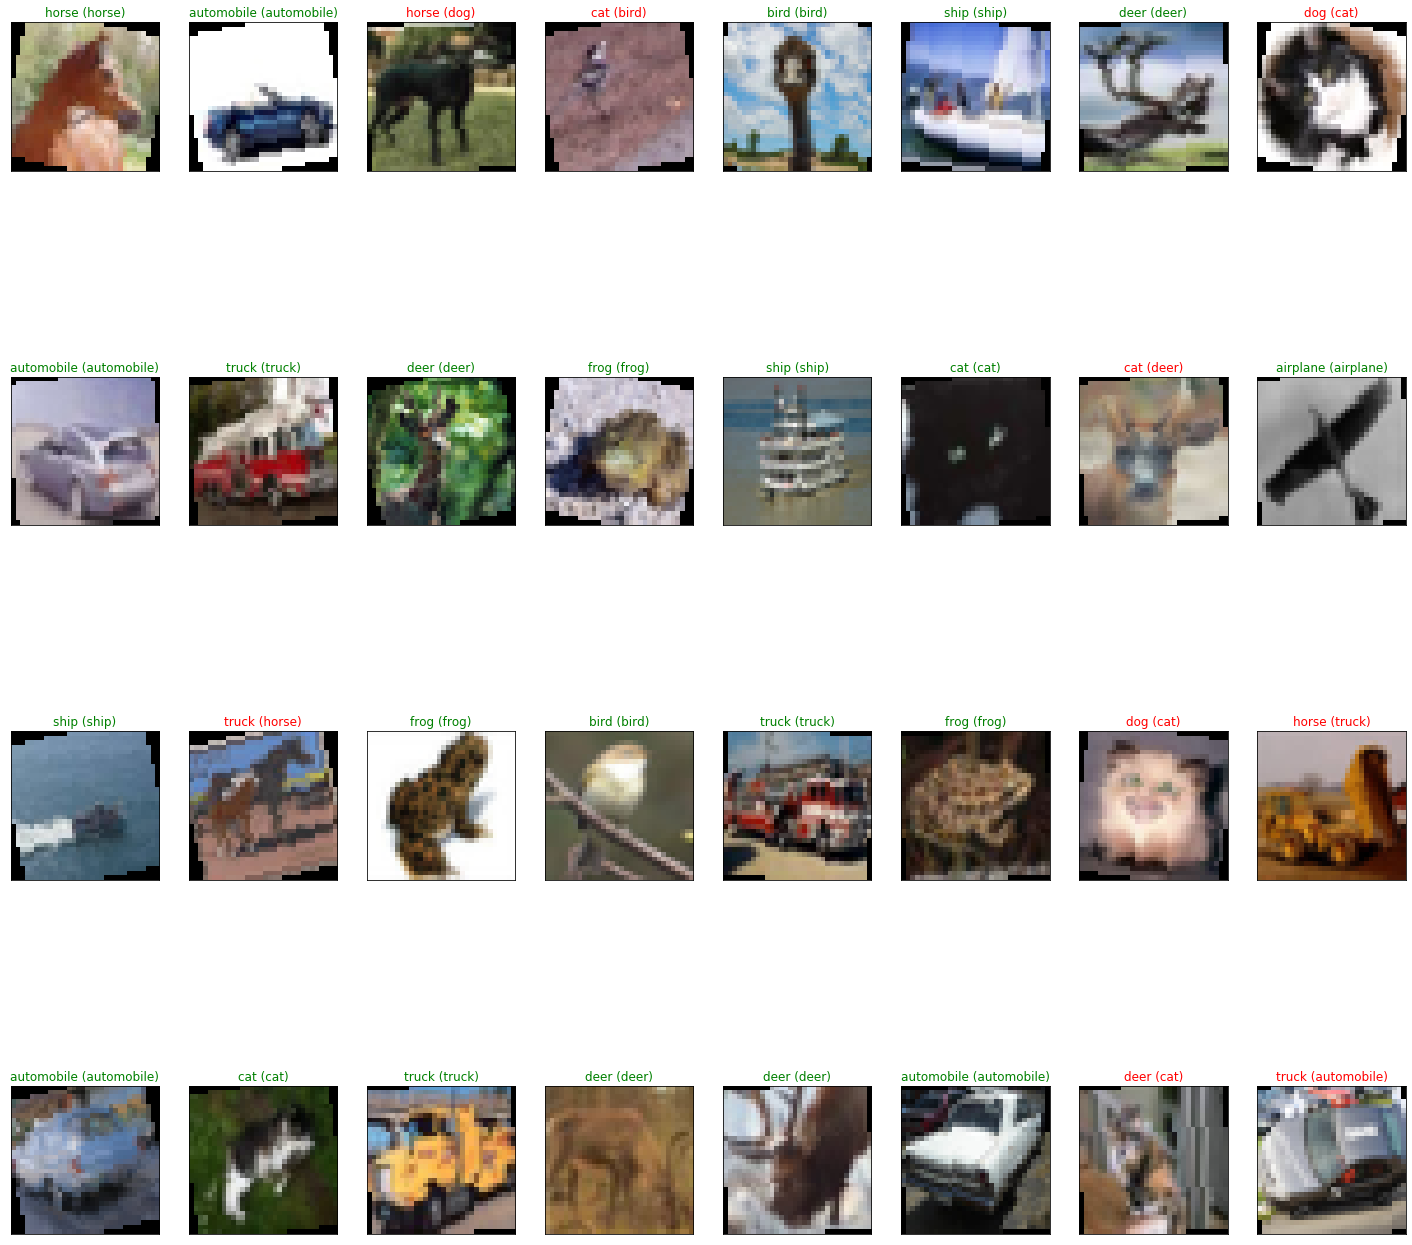

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if GPU:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not GPU else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25,25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Done!